All detected circles: [[[ 710  184   49]
  [ 660  188   43]
  [ 630  158   49]
  [ 712  212   49]
  [ 564  196   49]
  [ 746  244   49]
  [ 604  192   40]
  [ 532  250   45]
  [ 610  150   37]
  [ 774  254   45]
  [ 652  168   35]
  [ 708  142   34]
  [ 616  220   34]
  [ 758  318   37]
  [ 694  198   33]
  [ 656  238   34]
  [ 586  176   33]
  [ 416  224   29]
  [ 794  266   40]
  [ 676  260   34]
  [ 104  212   33]
  [ 496  298   39]
  [ 718  236   34]
  [ 586  218   29]
  [ 786  148   34]
  [ 686  224   29]
  [ 682  134   32]
  [ 750  194   28]
  [ 564  224   25]
  [ 710  164   22]
  [  58   56   29]
  [ 624  190   27]
  [ 652  212   24]
  [ 128  204   22]
  [ 596  276   33]
  [ 664  146   28]
  [ 766  156   27]
  [ 554  332   34]
  [ 596  254   30]
  [ 630  262   26]
  [  26   22   20]
  [ 508  150   24]
  [ 772  296   22]
  [ 732  278   24]
  [ 706  286   24]
  [ 566  142   24]
  [ 548  262   24]
  [ 748  164   19]
  [ 796  190   24]
  [ 658  282   16]
  [ 758  340   24]
  [ 610  

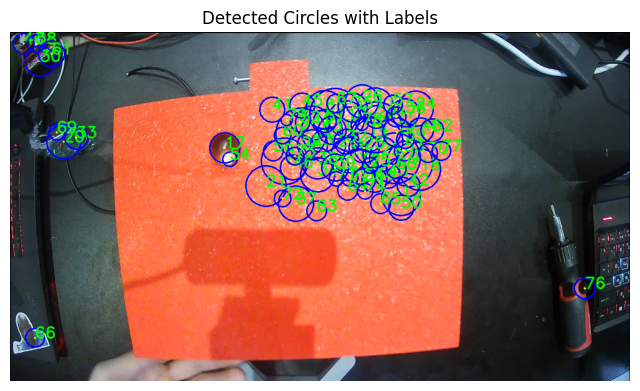

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Assume original_bgr is already loaded and circles is obtained from HoughCircles.
# For demonstration, here's how you might load your image:
data_name = "Ball1.png"
data_folder = os.path.join(os.getcwd(), "TestData")
original_bgr = cv2.imread(os.path.join(data_folder, data_name))

# Convert to grayscale and blur for circle detection.
gray = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.medianBlur(gray, 5)

# Detect circles using Hough Circle Transform.
circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=20,
    param1=50,
    param2=30,
    minRadius=5,
    maxRadius=50
)

# If circles were detected, annotate them on the original image.
if circles is not None:
    circles = np.uint16(np.around(circles))
    print("All detected circles:", circles)
    
    for i, (x_center, y_center, radius) in enumerate(circles[0]):
        print(f"Circle {i}: center=({x_center},{y_center}), radius={radius}")
        # Draw the circle's outer boundary.
        cv2.circle(original_bgr, (x_center, y_center), radius, (255, 0, 0), 2)
        # Draw the center of the circle.
        cv2.circle(original_bgr, (x_center, y_center), 2, (0, 255, 255), -1)
        # Label the circle number at its center.
        cv2.putText(original_bgr,
                    str(i),
                    (x_center, y_center),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.0,
                    (0, 255, 0),
                    2,
                    cv2.LINE_AA)
else:
    print("No circles detected.")

# Convert BGR to RGB for matplotlib display.
output_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(output_rgb)
plt.title("Detected Circles with Labels")
plt.axis('off')
plt.show()


In [3]:
correct_ball = 17 #The ball in picture above
print(circles[0][correct_ball])

# print(f"Circle {i}: center=({x_center},{y_center}), radius={radius}")

[416 224  29]


Base center (in pixels): (527, 390)
Ball center (in pixels): (np.uint16(416), np.uint16(224))
Pixel difference from base center to ball center: (errorX=-111, errorY=-166)


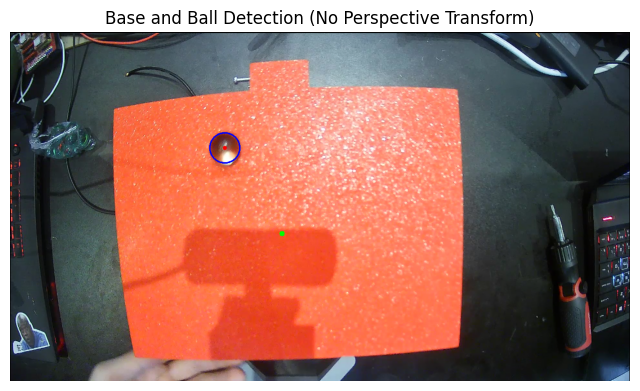

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------
# STEP 1: DETECT THE RED BASE AND FIND ITS CENTER
# ------------------------------------------------------
data_name = "Ball1.png"
data_folder = os.path.join(os.getcwd(), "TestData")
original_bgr = cv2.imread(os.path.join(data_folder, data_name))


# Convert to HSV
hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

# Define red thresholds in HSV
lower_red1 = np.array([0, 120, 70])   
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = mask1 | mask2

# Morphological cleanup
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) == 0:
    print("No red base detected.")
    exit()

# Sort by area and pick the largest
contours = sorted(contours, key=cv2.contourArea, reverse=True)
base_contour = contours[0]

# Get the moments of the largest red contour
M_base = cv2.moments(base_contour)
if M_base["m00"] != 0:
    base_cx = int(M_base["m10"] / M_base["m00"])
    base_cy = int(M_base["m01"] / M_base["m00"])
    base_center = (base_cx, base_cy)
    # Draw a small circle at the base center
    cv2.circle(original_bgr, base_center, 5, (0, 255, 0), -1)
    print(f"Base center (in pixels): {base_center}")
else:
    print("Could not compute base center.")
    exit()

# ------------------------------------------------------
# STEP 2: DETECT THE BALL AND FIND ITS CENTER
# ------------------------------------------------------
# Option A: Hough Circles (if the ball is fairly round)
# Convert to grayscale and blur
gray = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.medianBlur(gray, 5)

circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=20,
    param1=50,
    param2=30,
    minRadius=5,
    maxRadius=30
)

if circles is not None:
    circles = np.uint16(np.around(circles))
    # Take the first circle
    x_center, y_center, radius = circles[0][0]
    ball_center = (x_center, y_center)
    
    # Draw the detected ball
    cv2.circle(original_bgr, ball_center, radius, (255, 0, 0), 2)   # outer circle
    cv2.circle(original_bgr, ball_center, 4, (0, 0, 255), -1)     # center
    
    print(f"Ball center (in pixels): {ball_center}")

    # ------------------------------------------------------
    # STEP 3: COMPUTE DISTANCE (PIXELS) BETWEEN THE CENTERS
    # ------------------------------------------------------
    # errorX = ball_x - base_x
    # errorY = ball_y - base_y
    errorX = int(x_center) - base_cx
    errorY = int(y_center) - base_cy

    print(f"Pixel difference from base center to ball center: (errorX={errorX}, errorY={errorY})")
    
else:
    print("No ball detected using Hough Circles.")


# ------------------------------------------------------
# OPTIONAL: DISPLAY THE IMAGE
# ------------------------------------------------------
# Convert BGR to RGB for matplotlib
output_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(output_rgb)
plt.title("Base and Ball Detection (No Perspective Transform)")
plt.axis('off')
plt.show()
